In [26]:
%load_ext autoreload
%autoreload 2
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Check device availability
device = ''
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device = torch.device(device)
print("You are using device: %s" % device)

You are using device: mps


In [ ]:
# Preprocessed Data Paths
LABELS_OUTPUT = 'data/labels_multi_hot.pt'
W2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/w2v_embedded_visit_notes.pt'
D2V_EMBEDDED_VISIT_NOTES_OUTPUT = 'data/d2v_embedded_visit_notes.pt'

In [ ]:
# Load embedded visit notes
d2v_embedded_visit_notes = torch.load(D2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
w2v_embedded_visit_notes = torch.load(W2V_EMBEDDED_VISIT_NOTES_OUTPUT, weights_only=True)
labels = torch.load(LABELS_OUTPUT, weights_only=True)
print(d2v_embedded_visit_notes.shape)
print(w2v_embedded_visit_notes.shape)
print(labels.shape)

D2V_VECTOR_SIZE = d2v_embedded_visit_notes.shape[1]
W2V_VECTOR_SIZE = w2v_embedded_visit_notes.shape[1]

torch.Size([52722, 128])
torch.Size([52722, 100, 700])
torch.Size([52722, 6918])


In [ ]:
# Prepare data for DataLoader
embedded_visit_notes = [(d2v, w2v) for d2v, w2v in zip(d2v_embedded_visit_notes, w2v_embedded_visit_notes)]

In [ ]:
# Prepare Training, Validation, and Test Data

import numpy as np
from torch.utils.data import DataLoader

from utils import ICD9_Dataset


percentage = 0.5
batch_size = 50

num_samples = int(np.floor(percentage * labels.shape[0]))
train_samples = int(np.floor(0.7 * num_samples))
leftovers = num_samples - train_samples
valid_samples = train_samples + int(np.floor(0.5*leftovers))

print("Total Samples: ", str(num_samples))
print("Train Samples: ", str(train_samples))
print("Valid Samples: ", str(valid_samples - train_samples))
print("Test Samples: ", str(num_samples - valid_samples))


# Initialize Dataset
train_dataset = ICD9_Dataset(embedded_visit_notes[:train_samples],
                              labels[:train_samples])
valid_dataset = ICD9_Dataset(embedded_visit_notes[train_samples:valid_samples],
                            labels[train_samples:valid_samples])
test_dataset = ICD9_Dataset(embedded_visit_notes[valid_samples:num_samples],
                              labels[valid_samples:num_samples])
# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Total Samples:  26361
Train Samples:  18452
Valid Samples:  3954
Test Samples:  3955


In [ ]:
# Prepare a sample of data set to run through each part of the model

sample_set = embedded_visit_notes[0:5]
sample_set_d2v, sample_set_w2v = zip(*sample_set)
sample_set_d2v = torch.stack(sample_set_d2v)  
sample_set_w2v = torch.stack(sample_set_w2v)
print(sample_set_d2v.shape)
print(sample_set_w2v.shape)

torch.Size([5, 128])
torch.Size([5, 100, 700])


In [34]:
# Use CNN to process sample set of vector

import cnn 

my_cnn = cnn.CNN(device=device).to(device)

x = sample_set_w2v.to(device)
print(x.shape)

output = my_cnn.forward(x)
print(output.shape)


torch.Size([5, 100, 700])
torch.Size([5, 192])


In [35]:
# Use D2V Linear Layer to process sample set of vector

import importlib
import d2v_fc 

importlib.reload(d2v_fc)

dv2_model = d2v_fc.D2VFullyConnectedLayer(device=device).to(device)

x = sample_set_d2v.to(device)
print(x.shape)

output = dv2_model.forward(x)
print(output.shape)

torch.Size([5, 128])
torch.Size([5, 128])


In [36]:
# Use Combined Model to process sample set of data

import importlib
import icd9_dl_model 

importlib.reload(icd9_dl_model)
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1]).to(device)

x = (sample_set_d2v, sample_set_w2v)

output = model.forward(x)
print(output)

tensor([[-0.1081, -0.0429, -1.2661,  ..., -0.8006,  1.0319, -0.0136],
        [ 0.2664, -0.1808, -0.4983,  ..., -0.8939,  0.7767,  0.1162],
        [ 0.4120,  0.4688, -0.1329,  ..., -0.3655, -0.9158, -0.0140],
        [-0.4649, -0.8796, -0.2130,  ..., -0.1782, -0.5436,  0.1966],
        [ 0.5323,  0.7392, -1.1745,  ..., -0.3821,  0.4073, -1.3232]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [ ]:
# Train and Plot function to train model and plot loss and accuracy curves

%load_ext autoreload
%autoreload 2
from utils import train, evaluate, plot_curves
import torch.nn as nn

def train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename='', epochs=10, threshold=0.2):
    train_accuracies = []
    valid_accuracies = []
    train_losses = []
    valid_losses = []
    for epoch_idx in range(epochs):
        print("-----------------------------------")
        print("Epoch %d" % (epoch_idx+1))
        print("-----------------------------------")

        train_accuracy, train_loss, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device=device, threshold=threshold)

        if scheduler:
            scheduler.step(train_loss)

        valid_accuracy, valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_loader, criterion, device=device, threshold=threshold)

        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_loss, valid_loss))
        print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, valid_accuracy))
        print("Training Precision: %.4f. Validation Precision: %.4f. " % (train_precision, valid_precision))
        print("Training Recall: %.4f. Validation Recall: %.4f. " % (train_recall, valid_recall))
        print("Training F1: %.4f. Validation F1: %.4f. " % (train_f1, valid_f1))

    plot_curves(train_accuracies, valid_accuracies, "Accuracy", filename, output_dir='outputs/')
    plot_curves(train_losses, valid_losses, "Loss", filename, output_dir='outputs/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:03<00:00, 20.24it/s]


Training Loss: 78.3890. Validation Loss: 73.9905. 
Training Accuracy: 0.9520. Validation Accuracy: 0.9563. 
Training Precision: 0.0247. Validation Precision: 0.0288. 
Training Recall: 0.6981. Validation Recall: 0.7522. 
Training F1: 0.0477. Validation F1: 0.0555. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 49.96it/s]


Training Loss: 72.9216. Validation Loss: 71.2609. 
Training Accuracy: 0.9519. Validation Accuracy: 0.9538. 
Training Precision: 0.0266. Validation Precision: 0.0284. 
Training Recall: 0.7700. Validation Recall: 0.7919. 
Training F1: 0.0514. Validation F1: 0.0548. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 48.95it/s]


Training Loss: 71.5293. Validation Loss: 70.4416. 
Training Accuracy: 0.9458. Validation Accuracy: 0.9508. 
Training Precision: 0.0246. Validation Precision: 0.0275. 
Training Recall: 0.7992. Validation Recall: 0.8164. 
Training F1: 0.0477. Validation F1: 0.0531. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 53.16it/s]


Training Loss: 71.0323. Validation Loss: 70.1486. 
Training Accuracy: 0.9419. Validation Accuracy: 0.9479. 
Training Precision: 0.0234. Validation Precision: 0.0264. 
Training Recall: 0.8156. Validation Recall: 0.8288. 
Training F1: 0.0455. Validation F1: 0.0512. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 58.46it/s]


Training Loss: 70.6804. Validation Loss: 70.1373. 
Training Accuracy: 0.9395. Validation Accuracy: 0.9471. 
Training Precision: 0.0227. Validation Precision: 0.0262. 
Training Recall: 0.8239. Validation Recall: 0.8321. 
Training F1: 0.0442. Validation F1: 0.0508. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 46.65it/s]


Training Loss: 70.4001. Validation Loss: 69.9196. 
Training Accuracy: 0.9375. Validation Accuracy: 0.9459. 
Training Precision: 0.0222. Validation Precision: 0.0257. 
Training Recall: 0.8304. Validation Recall: 0.8354. 
Training F1: 0.0432. Validation F1: 0.0498. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 49.87it/s]


Training Loss: 70.2498. Validation Loss: 69.9626. 
Training Accuracy: 0.9356. Validation Accuracy: 0.9457. 
Training Precision: 0.0217. Validation Precision: 0.0256. 
Training Recall: 0.8363. Validation Recall: 0.8366. 
Training F1: 0.0422. Validation F1: 0.0497. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 57.89it/s]


Training Loss: 70.2624. Validation Loss: 69.4784. 
Training Accuracy: 0.9350. Validation Accuracy: 0.9440. 
Training Precision: 0.0215. Validation Precision: 0.0250. 
Training Recall: 0.8389. Validation Recall: 0.8445. 
Training F1: 0.0420. Validation F1: 0.0485. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 50.97it/s]


Training Loss: 70.2073. Validation Loss: 69.4971. 
Training Accuracy: 0.9340. Validation Accuracy: 0.9434. 
Training Precision: 0.0214. Validation Precision: 0.0249. 
Training Recall: 0.8427. Validation Recall: 0.8485. 
Training F1: 0.0416. Validation F1: 0.0484. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 55.41it/s]


Training Loss: 69.9362. Validation Loss: 69.9747. 
Training Accuracy: 0.9339. Validation Accuracy: 0.9430. 
Training Precision: 0.0213. Validation Precision: 0.0249. 
Training Recall: 0.8434. Validation Recall: 0.8477. 
Training F1: 0.0415. Validation F1: 0.0483. 


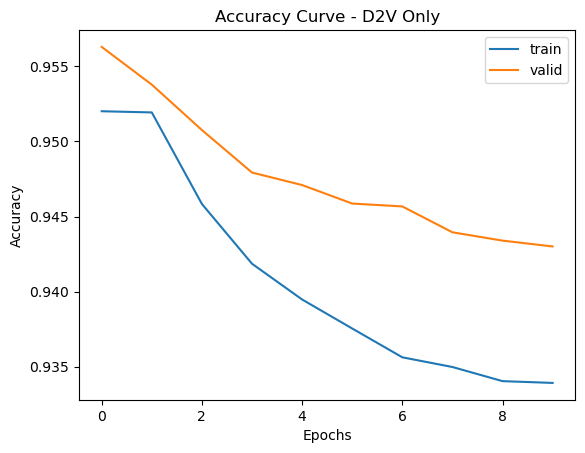

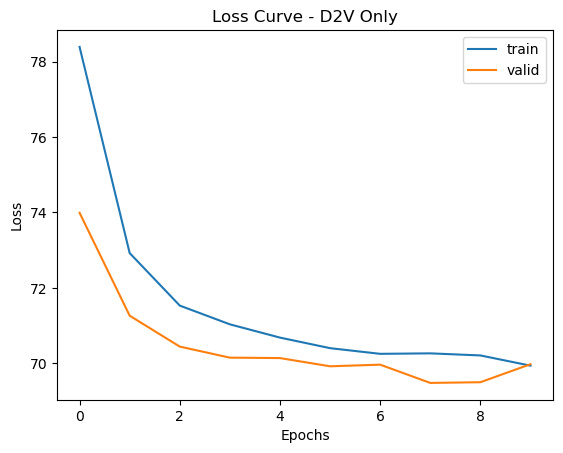

In [ ]:
# Use D2V Part of the Model Only

import icd9_dl_model

learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], specific_model="d2v").to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
file_name = "D2V Only"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2, epochs=epochs)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.43it/s]


Training Loss: 75.6249. Validation Loss: 71.7539. 
Training Accuracy: 0.9551. Validation Accuracy: 0.9672. 
Training Precision: 0.0283. Validation Precision: 0.0368. 
Training Recall: 0.7138. Validation Recall: 0.7317. 
Training F1: 0.0544. Validation F1: 0.0701. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.39it/s]


Training Loss: 70.0345. Validation Loss: 69.3697. 
Training Accuracy: 0.9713. Validation Accuracy: 0.9751. 
Training Precision: 0.0420. Validation Precision: 0.0484. 
Training Recall: 0.7298. Validation Recall: 0.7313. 
Training F1: 0.0794. Validation F1: 0.0907. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 38.09it/s]


Training Loss: 67.4977. Validation Loss: 67.9297. 
Training Accuracy: 0.9772. Validation Accuracy: 0.9799. 
Training Precision: 0.0525. Validation Precision: 0.0580. 
Training Recall: 0.7293. Validation Recall: 0.7114. 
Training F1: 0.0979. Validation F1: 0.1073. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.76it/s]


Training Loss: 65.6713. Validation Loss: 67.5419. 
Training Accuracy: 0.9812. Validation Accuracy: 0.9842. 
Training Precision: 0.0622. Validation Precision: 0.0707. 
Training Recall: 0.7158. Validation Recall: 0.6793. 
Training F1: 0.1143. Validation F1: 0.1279. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.84it/s]


Training Loss: 64.1338. Validation Loss: 66.5592. 
Training Accuracy: 0.9846. Validation Accuracy: 0.9871. 
Training Precision: 0.0734. Validation Precision: 0.0824. 
Training Recall: 0.6953. Validation Recall: 0.6527. 
Training F1: 0.1327. Validation F1: 0.1462. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.43it/s]


Training Loss: 62.9192. Validation Loss: 66.6810. 
Training Accuracy: 0.9876. Validation Accuracy: 0.9899. 
Training Precision: 0.0872. Validation Precision: 0.0987. 
Training Recall: 0.6674. Validation Recall: 0.6055. 
Training F1: 0.1540. Validation F1: 0.1695. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 30.86it/s]


Training Loss: 61.9117. Validation Loss: 66.3907. 
Training Accuracy: 0.9901. Validation Accuracy: 0.9918. 
Training Precision: 0.1034. Validation Precision: 0.1140. 
Training Recall: 0.6302. Validation Recall: 0.5680. 
Training F1: 0.1773. Validation F1: 0.1895. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.08it/s]


Training Loss: 60.9892. Validation Loss: 66.6611. 
Training Accuracy: 0.9923. Validation Accuracy: 0.9938. 
Training Precision: 0.1247. Validation Precision: 0.1385. 
Training Recall: 0.5871. Validation Recall: 0.5077. 
Training F1: 0.2051. Validation F1: 0.2169. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.72it/s]


Training Loss: 60.0191. Validation Loss: 67.2089. 
Training Accuracy: 0.9939. Validation Accuracy: 0.9950. 
Training Precision: 0.1488. Validation Precision: 0.1623. 
Training Recall: 0.5454. Validation Recall: 0.4566. 
Training F1: 0.2329. Validation F1: 0.2385. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.28it/s]


Training Loss: 59.3416. Validation Loss: 67.0938. 
Training Accuracy: 0.9950. Validation Accuracy: 0.9959. 
Training Precision: 0.1723. Validation Precision: 0.1855. 
Training Recall: 0.5117. Validation Recall: 0.4176. 
Training F1: 0.2568. Validation F1: 0.2559. 
-----------------------------------
Epoch 11
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 30.78it/s]


Training Loss: 58.6924. Validation Loss: 67.0710. 
Training Accuracy: 0.9957. Validation Accuracy: 0.9963. 
Training Precision: 0.1940. Validation Precision: 0.2013. 
Training Recall: 0.4862. Validation Recall: 0.3928. 
Training F1: 0.2761. Validation F1: 0.2647. 
-----------------------------------
Epoch 12
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.71it/s]


Training Loss: 58.4015. Validation Loss: 67.4608. 
Training Accuracy: 0.9960. Validation Accuracy: 0.9966. 
Training Precision: 0.2086. Validation Precision: 0.2147. 
Training Recall: 0.4708. Validation Recall: 0.3787. 
Training F1: 0.2875. Validation F1: 0.2724. 
-----------------------------------
Epoch 13
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.74it/s]


Training Loss: 57.7748. Validation Loss: 67.7053. 
Training Accuracy: 0.9963. Validation Accuracy: 0.9967. 
Training Precision: 0.2190. Validation Precision: 0.2230. 
Training Recall: 0.4617. Validation Recall: 0.3660. 
Training F1: 0.2957. Validation F1: 0.2757. 
-----------------------------------
Epoch 14
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.23it/s]


Training Loss: 57.4565. Validation Loss: 67.6904. 
Training Accuracy: 0.9964. Validation Accuracy: 0.9969. 
Training Precision: 0.2275. Validation Precision: 0.2298. 
Training Recall: 0.4563. Validation Recall: 0.3585. 
Training F1: 0.3024. Validation F1: 0.2782. 
-----------------------------------
Epoch 15
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.31it/s]


Training Loss: 57.0713. Validation Loss: 68.4815. 
Training Accuracy: 0.9966. Validation Accuracy: 0.9969. 
Training Precision: 0.2366. Validation Precision: 0.2341. 
Training Recall: 0.4561. Validation Recall: 0.3518. 
Training F1: 0.3100. Validation F1: 0.2794. 


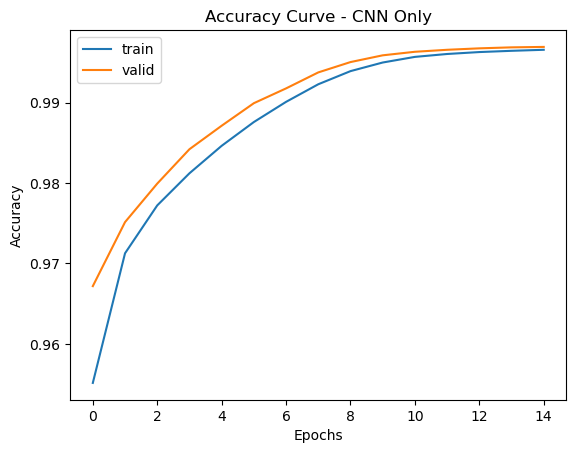

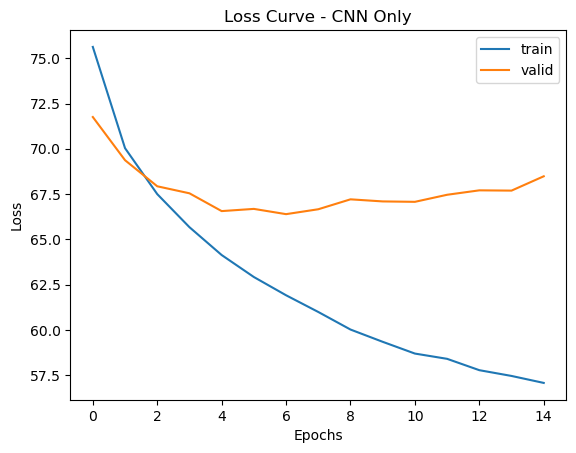

In [39]:
# # Use CNN Part of the Model Only

import icd9_dl_model 

cnn_dropout = 0.25
learning_rate = 0.001
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], specific_model="cnn", cnn_dropout_rate=cnn_dropout).to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 15
file_name = "CNN Only"
threshold = 0.2


train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2, epochs=epochs)

-----------------------------------
Epoch 1
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.00it/s]


Training Loss: 74.5327. Validation Loss: 70.6098. 
Training Accuracy: 0.9586. Validation Accuracy: 0.9657. 
Training Precision: 0.0302. Validation Precision: 0.0368. 
Training Recall: 0.7185. Validation Recall: 0.7633. 
Training F1: 0.0579. Validation F1: 0.0703. 
-----------------------------------
Epoch 2
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 37.08it/s]


Training Loss: 69.1127. Validation Loss: 67.8088. 
Training Accuracy: 0.9665. Validation Accuracy: 0.9722. 
Training Precision: 0.0379. Validation Precision: 0.0453. 
Training Recall: 0.7678. Validation Recall: 0.7672. 
Training F1: 0.0722. Validation F1: 0.0854. 
-----------------------------------
Epoch 3
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.77it/s]


Training Loss: 66.5649. Validation Loss: 66.9440. 
Training Accuracy: 0.9723. Validation Accuracy: 0.9774. 
Training Precision: 0.0459. Validation Precision: 0.0542. 
Training Recall: 0.7735. Validation Recall: 0.7511. 
Training F1: 0.0866. Validation F1: 0.1010. 
-----------------------------------
Epoch 4
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.84it/s]


Training Loss: 64.7172. Validation Loss: 66.5892. 
Training Accuracy: 0.9769. Validation Accuracy: 0.9816. 
Training Precision: 0.0541. Validation Precision: 0.0644. 
Training Recall: 0.7631. Validation Recall: 0.7240. 
Training F1: 0.1010. Validation F1: 0.1181. 
-----------------------------------
Epoch 5
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 35.79it/s]


Training Loss: 63.1909. Validation Loss: 66.0161. 
Training Accuracy: 0.9813. Validation Accuracy: 0.9853. 
Training Precision: 0.0647. Validation Precision: 0.0762. 
Training Recall: 0.7437. Validation Recall: 0.6889. 
Training F1: 0.1189. Validation F1: 0.1371. 
-----------------------------------
Epoch 6
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 31.03it/s]


Training Loss: 62.0679. Validation Loss: 66.2457. 
Training Accuracy: 0.9851. Validation Accuracy: 0.9882. 
Training Precision: 0.0784. Validation Precision: 0.0904. 
Training Recall: 0.7177. Validation Recall: 0.6524. 
Training F1: 0.1411. Validation F1: 0.1587. 
-----------------------------------
Epoch 7
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 38.93it/s]


Training Loss: 60.8742. Validation Loss: 66.0318. 
Training Accuracy: 0.9883. Validation Accuracy: 0.9914. 
Training Precision: 0.0949. Validation Precision: 0.1124. 
Training Recall: 0.6824. Validation Recall: 0.5894. 
Training F1: 0.1662. Validation F1: 0.1884. 
-----------------------------------
Epoch 8
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 45.42it/s]


Training Loss: 59.9557. Validation Loss: 66.1882. 
Training Accuracy: 0.9911. Validation Accuracy: 0.9932. 
Training Precision: 0.1160. Validation Precision: 0.1318. 
Training Recall: 0.6398. Validation Recall: 0.5378. 
Training F1: 0.1958. Validation F1: 0.2113. 
-----------------------------------
Epoch 9
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 38.32it/s]


Training Loss: 59.2920. Validation Loss: 66.4874. 
Training Accuracy: 0.9928. Validation Accuracy: 0.9944. 
Training Precision: 0.1374. Validation Precision: 0.1522. 
Training Recall: 0.6043. Validation Recall: 0.4983. 
Training F1: 0.2230. Validation F1: 0.2325. 
-----------------------------------
Epoch 10
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.60it/s]


Training Loss: 58.4716. Validation Loss: 66.6628. 
Training Accuracy: 0.9940. Validation Accuracy: 0.9951. 
Training Precision: 0.1556. Validation Precision: 0.1683. 
Training Recall: 0.5750. Validation Recall: 0.4729. 
Training F1: 0.2441. Validation F1: 0.2473. 
-----------------------------------
Epoch 11
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 46.64it/s]


Training Loss: 58.0393. Validation Loss: 66.7228. 
Training Accuracy: 0.9946. Validation Accuracy: 0.9956. 
Training Precision: 0.1712. Validation Precision: 0.1803. 
Training Recall: 0.5577. Validation Recall: 0.4518. 
Training F1: 0.2611. Validation F1: 0.2565. 
-----------------------------------
Epoch 12
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 45.63it/s]


Training Loss: 57.4810. Validation Loss: 67.5629. 
Training Accuracy: 0.9950. Validation Accuracy: 0.9959. 
Training Precision: 0.1812. Validation Precision: 0.1919. 
Training Recall: 0.5487. Validation Recall: 0.4344. 
Training F1: 0.2713. Validation F1: 0.2652. 
-----------------------------------
Epoch 13
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 44.67it/s]


Training Loss: 57.2022. Validation Loss: 67.7839. 
Training Accuracy: 0.9953. Validation Accuracy: 0.9961. 
Training Precision: 0.1916. Validation Precision: 0.1989. 
Training Recall: 0.5415. Validation Recall: 0.4272. 
Training F1: 0.2818. Validation F1: 0.2702. 
-----------------------------------
Epoch 14
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 36.63it/s]


Training Loss: 56.7693. Validation Loss: 67.7534. 
Training Accuracy: 0.9955. Validation Accuracy: 0.9962. 
Training Precision: 0.1981. Validation Precision: 0.2014. 
Training Recall: 0.5391. Validation Recall: 0.4223. 
Training F1: 0.2885. Validation F1: 0.2714. 
-----------------------------------
Epoch 15
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 33.40it/s]


Training Loss: 56.5532. Validation Loss: 67.6168. 
Training Accuracy: 0.9956. Validation Accuracy: 0.9961. 
Training Precision: 0.2020. Validation Precision: 0.2013. 
Training Recall: 0.5416. Validation Recall: 0.4279. 
Training F1: 0.2932. Validation F1: 0.2724. 
-----------------------------------
Epoch 16
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:25<00:00,  3.19it/s]


Training Loss: 56.2507. Validation Loss: 67.6657. 
Training Accuracy: 0.9956. Validation Accuracy: 0.9962. 
Training Precision: 0.2046. Validation Precision: 0.2054. 
Training Recall: 0.5449. Validation Recall: 0.4228. 
Training F1: 0.2965. Validation F1: 0.2749. 
-----------------------------------
Epoch 17
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 34.02it/s]


Training Loss: 56.2002. Validation Loss: 68.2243. 
Training Accuracy: 0.9957. Validation Accuracy: 0.9964. 
Training Precision: 0.2098. Validation Precision: 0.2143. 
Training Recall: 0.5426. Validation Recall: 0.4100. 
Training F1: 0.3013. Validation F1: 0.2800. 
-----------------------------------
Epoch 18
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 38.20it/s]


Training Loss: 55.9314. Validation Loss: 68.2524. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9963. 
Training Precision: 0.2125. Validation Precision: 0.2094. 
Training Recall: 0.5435. Validation Recall: 0.4170. 
Training F1: 0.3043. Validation F1: 0.2776. 
-----------------------------------
Epoch 19
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 52.35it/s]


Training Loss: 55.7258. Validation Loss: 68.1909. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9963. 
Training Precision: 0.2130. Validation Precision: 0.2109. 
Training Recall: 0.5476. Validation Recall: 0.4164. 
Training F1: 0.3055. Validation F1: 0.2786. 
-----------------------------------
Epoch 20
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 53.51it/s]


Training Loss: 55.5410. Validation Loss: 69.0544. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9963. 
Training Precision: 0.2137. Validation Precision: 0.2104. 
Training Recall: 0.5519. Validation Recall: 0.4171. 
Training F1: 0.3071. Validation F1: 0.2780. 
-----------------------------------
Epoch 21
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 54.11it/s]


Training Loss: 55.4664. Validation Loss: 69.0196. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9964. 
Training Precision: 0.2136. Validation Precision: 0.2123. 
Training Recall: 0.5564. Validation Recall: 0.4147. 
Training F1: 0.3076. Validation F1: 0.2796. 
-----------------------------------
Epoch 22
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 54.53it/s]


Training Loss: 55.3107. Validation Loss: 69.0092. 
Training Accuracy: 0.9958. Validation Accuracy: 0.9963. 
Training Precision: 0.2160. Validation Precision: 0.2105. 
Training Recall: 0.5571. Validation Recall: 0.4187. 
Training F1: 0.3102. Validation F1: 0.2791. 
-----------------------------------
Epoch 23
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:02<00:00, 32.15it/s]


Training Loss: 55.1429. Validation Loss: 68.9790. 
Training Accuracy: 0.9957. Validation Accuracy: 0.9963. 
Training Precision: 0.2146. Validation Precision: 0.2093. 
Training Recall: 0.5638. Validation Recall: 0.4219. 
Training F1: 0.3100. Validation F1: 0.2787. 
-----------------------------------
Epoch 24
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 55.43it/s]


Training Loss: 54.9980. Validation Loss: 68.8315. 
Training Accuracy: 0.9957. Validation Accuracy: 0.9962. 
Training Precision: 0.2151. Validation Precision: 0.2056. 
Training Recall: 0.5686. Validation Recall: 0.4284. 
Training F1: 0.3110. Validation F1: 0.2762. 
-----------------------------------
Epoch 25
-----------------------------------


Evaluating: 100%|##########| 80/80 [00:01<00:00, 54.57it/s]


Training Loss: 54.8729. Validation Loss: 69.0574. 
Training Accuracy: 0.9957. Validation Accuracy: 0.9961. 
Training Precision: 0.2148. Validation Precision: 0.2012. 
Training Recall: 0.5731. Validation Recall: 0.4315. 
Training F1: 0.3116. Validation F1: 0.2736. 


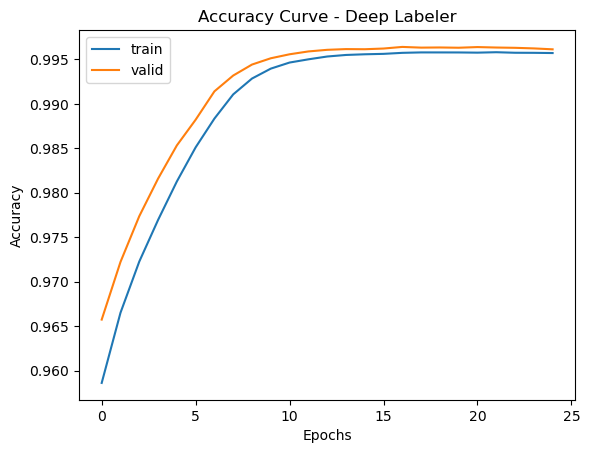

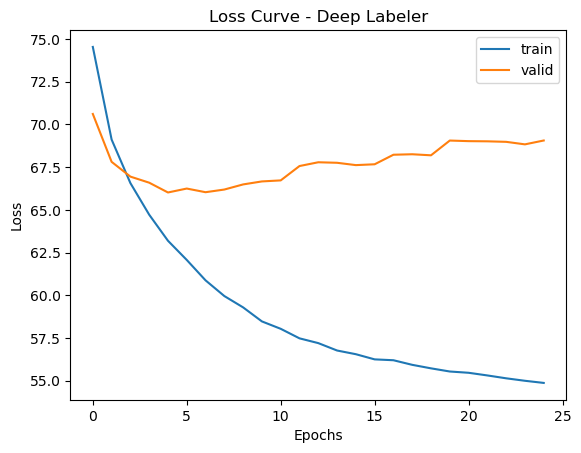

In [40]:
# Combined Deep Labeler using D2V AND W2V

import icd9_dl_model 

learning_rate = 0.001
cnn_dropout = 0.25
d2v_dropout = 0.75
model = icd9_dl_model.ICD9DeepLearningModel(device=device, num_labels=labels.shape[1], d2v_dropout_rate=d2v_dropout, cnn_dropout_rate=cnn_dropout).to(device)
scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 25
file_name = "Deep Labeler"
threshold = 0.2

train_and_plot(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, filename=file_name, threshold=0.2, epochs=epochs)

In [41]:

# Use Test data against model and various thresholds

from utils import score_model
model.eval() 

all_true_labels = []
all_outputs = []

with torch.no_grad(): 
    for inputs, labels in test_loader:
        outputs = model(inputs)
        
        all_outputs.extend(outputs.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

thresh_ls = [0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
precision = []
recall = []
f1 = []
for i in thresh_ls:
  metrics = score_model(all_true_labels, all_outputs, threshold=i)
  precision.append(metrics[1])
  recall.append(metrics[2])
  f1.append(metrics[3])
  print('threshold:', i,
        *["{}: {}".format(name, num) for name, num in zip(
          ["accuracy", "precision", "recall","f1"],
          metrics)])

threshold: 0.005 accuracy: 0.9953796121369746 precision: 0.1764358374673258 recall: 0.46934469990527755 f1: 0.256462436993077
threshold: 0.05 accuracy: 0.9955455801735994 precision: 0.18133038143685234 recall: 0.4619607336605518 f1: 0.2604342391106469
threshold: 0.1 accuracy: 0.9957214529311944 precision: 0.18677584769069697 recall: 0.45322052871781526 f1: 0.26453477414085536
threshold: 0.2 accuracy: 0.9960494417355703 precision: 0.1977818310190631 recall: 0.43419013174890114 f1: 0.271768130002425
threshold: 0.3 accuracy: 0.9963479722185369 precision: 0.20951584162718914 recall: 0.4151166795832248 f1: 0.2784790017907685
threshold: 0.4 accuracy: 0.9966117448061435 precision: 0.221625720716925 recall: 0.3963661413932653 f1: 0.28429154861073536
threshold: 0.5 accuracy: 0.9968494215606405 precision: 0.23453277768873185 recall: 0.37800309997416603 f1: 0.2894658753709194
threshold: 0.6 accuracy: 0.9970575668961565 precision: 0.2474826118550811 recall: 0.35925256178420656 f1: 0.29307271497940

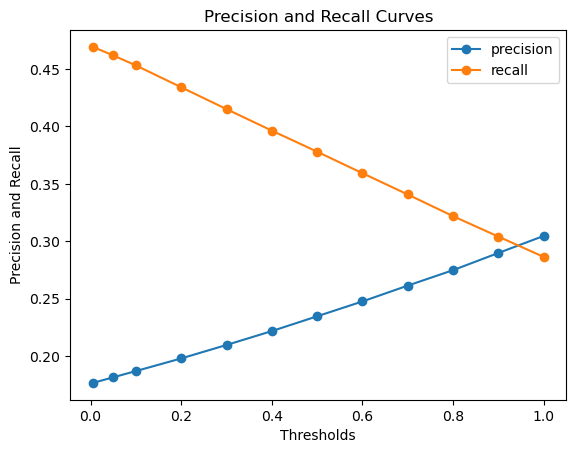

In [42]:
# Graph Precision Recall Curves

import matplotlib.pyplot as plt
import os

output_dir = "outputs/"

plt.plot(thresh_ls, precision, label='precision', marker='o')
plt.plot(thresh_ls, recall, label='recall', marker='o')

plt.xlabel('Thresholds')
plt.ylabel("Precision and Recall")
plt.legend()
plt.title("Precision and Recall Curves")
plt.savefig(os.path.join(output_dir, "Precision Recall DeepLabeler" + '.png'))
plt.show()

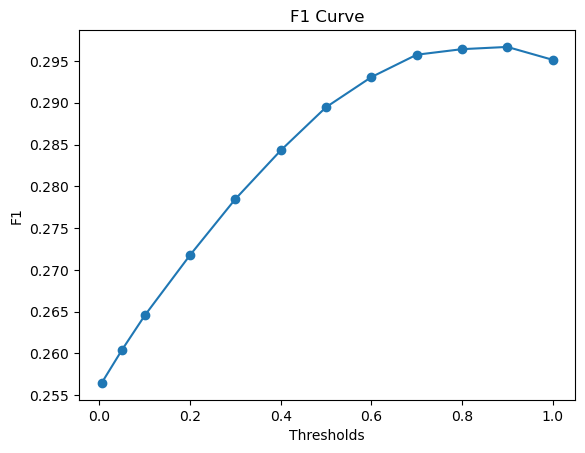

In [43]:
# Graph F1 Curves

import matplotlib.pyplot as plt

plt.plot(thresh_ls, f1, label='f1', marker='o')
plt.xlabel('Thresholds')
plt.ylabel("F1")
plt.title("F1 Curve")
plt.savefig(os.path.join(output_dir, "F1 DeepLabeler" + '.png'))
plt.show()